From: https://github.com/mozilla/TTS/blob/master/dataset_analysis/CheckDatasetSNR.ipynb

In [1]:
!wget http://www.cs.cmu.edu/~robust/archive/algorithms/WADA_SNR_IS_2008/WadaSNR.tar.gz
!mkdir WADA_SNR_IS_2008/ && tar -xvf WadaSNR.tar.gz -C WADA_SNR_IS_2008
!sudo apt-get install ffmpeg
!pip install soundfile

--2020-06-26 20:46:35--  http://www.cs.cmu.edu/~robust/archive/algorithms/WADA_SNR_IS_2008/WadaSNR.tar.gz
Resolving www.cs.cmu.edu (www.cs.cmu.edu)... 128.2.42.95
Connecting to www.cs.cmu.edu (www.cs.cmu.edu)|128.2.42.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2878515 (2.7M) [application/x-gzip]
Saving to: ‘WadaSNR.tar.gz’

WadaSNR.tar.gz      100%[===================>]   2.75M  1.59MB/s    in 1.7s    

2020-06-26 20:46:37 (1.59 MB/s) - ‘WadaSNR.tar.gz’ saved [2878515/2878515]

Build/
Build/AudioFile.o
Build/case.o
Build/ckd_alloc.o
Build/SNREst.o
Build/Table.o
Build/Makefile
Build/info.o
Build/Main.o
Build/cmd_ln.o
Build/hash.o
Build/err.o
Build/glist.o
Build/fe_sigproc.o
Build/Config.o
Doc/
Exe/
Exe/WADASNR
Exe/Alpha0.400000.txt
Header/
Header/SNREst.h
Header/Config.h
Header/Debug/
Header/AudioFile.h
Header/Table.h
README
SampleCorrupt/
SampleCorrupt/sb02_Clean.sph
SampleCorrupt/sb01_20dB_Music.sph
SampleCorrupt/sb02_00dB_White.sph
SampleCorrupt/sb01_

In [2]:
!sudo apt install musl-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  musl
Recommended packages:
  linux-musl-dev
The following NEW packages will be installed:
  musl musl-dev
0 upgraded, 2 newly installed, 0 to remove and 33 not upgraded.
Need to get 905 kB of archives.
After this operation, 3,973 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 musl amd64 1.1.19-1 [367 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 musl-dev amd64 1.1.19-1 [538 kB]
Fetched 905 kB in 1s (1,103 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 2.)
debco

In [3]:
!sudo apt-get install gcc-multilib g++-multilib

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  g++-7-multilib gcc-7-multilib lib32asan4 lib32atomic1 lib32cilkrts5
  lib32gcc-7-dev lib32gomp1 lib32itm1 lib32mpx2 lib32quadmath0
  lib32stdc++-7-dev lib32ubsan0 libc6-dev-i386 libc6-dev-x32 libc6-x32
  libx32asan4 libx32atomic1 libx32cilkrts5 libx32gcc-7-dev libx32gcc1
  libx32gomp1 libx32itm1 libx32quadmath0 libx32stdc++-7-dev libx32stdc++6
  libx32ubsan0
Suggested packages:
  lib32stdc++6-7-dbg libx32stdc++6-7-dbg
The following NEW packages will be installed:
  g++-7-multilib g++-multilib gcc-7-multilib gcc-multilib lib32asan4
  lib32atomic1 lib32cilkrts5 lib32gcc-7-dev lib32gomp1 lib32itm1 lib32mpx2
  lib32quadmath0 lib32stdc++-7-dev lib32ubsan0 libc6-dev-i386 libc6-dev-x32
  libc6-x32 libx32asa

In [4]:
!cd /content/WADA_SNR_IS_2008/Build/ && rm -rf *.o && make clean && make

rm -fr *.o *.core ../Exe/WADASNR
gcc  -I../Header -I../src/libs3decoder -I../src -I../src/libutil -I../src/ANModel -O3 -m32 -c ../src/libs3decoder/fe_sigproc.c ../src/libutil/case.c ../src/libutil/ckd_alloc.c ../src/libutil/cmd_ln.c ../src/libutil/err.c ../src/libutil/glist.c ../src/libutil/hash.c ../src/libutil/info.c 
../src/libutil/info.c: In function ‘print_appl_info’:
../src/libutil/info.c:51:2: warning: ignoring return value of ‘getcwd’, declared with attribute warn_unused_result [-Wunused-result]
  getcwd (path, sizeof(path));
  ^~~~~~~~~~~~~~~~~~~~~~~~~~~
g++ -I../Header -I../src/libs3decoder -I../src -I../src/libutil -I../src/ANModel -O3 -m32 -c ../Source/AudioFile.cpp ../Source/Config.cpp ../Source/Main.cpp ../Source/Table.cpp ../Source/SNREst.cpp 
../Source/AudioFile.cpp: In member function ‘int32 CAudioFile::GetFileSize()’:
../Source/AudioFile.cpp:165:122: warning: format ‘%d’ expects argument of type ‘int’, but argument 4 has type ‘long int’ [-Wformat=]
  fprintf(g_logFile

In [5]:
import os, sys
import glob
import subprocess
import tempfile
import IPython
import soundfile as sf
import numpy as np
from tqdm import tqdm
from multiprocessing import Pool
from matplotlib import pylab as plt
%matplotlib inline

In [7]:
# TODO: Replace with wavs folder in cloned repo
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded = drive.CreateFile({'id':"1K6v8VFZEQ98EMzlwr8gaDzrrVRKEaPvY"})
downloaded.GetContentFile('wavs.tar.gz')
!tar -xvf wavs.tar.gz

wavs/
wavs/marker_19.wav
wavs/marker_21.wav
wavs/marker_20.wav


In [8]:
# Set the meta parameters
DATA_PATH = "/content/wavs"
NUM_PROC = 1
CURRENT_PATH = "/content"

In [9]:
def compute_file_snr(file_path):
    """ Convert given file to required format with FFMPEG and process with WADA."""
    _, sr = sf.read(file_path)
    new_file = file_path.replace(".wav", "_tmp.wav")
    print(new_file)
    if sr != 16000:
      command = f'ffmpeg -i "{file_path}" -ac 1 -acodec pcm_s16le -y -ar 16000 "{new_file}"'
    else:
      command = f'cp "{file_path}" "{new_file}"'
    os.system(command)
    output = !/content/WADA_SNR_IS_2008/Exe/WADASNR -i {new_file} -t /content/WADA_SNR_IS_2008/Exe/Alpha0.400000.txt -ifmt mswav 
    snr = float(output[-2].split()[-2])
    os.system(f'rm "{new_file}"')
    return snr, file_path

In [10]:
!/content/WADA_SNR_IS_2008/Exe/WADASNR -i /content/WADA_SNR_IS_2008/SampleCorrupt/sb01_00dB_White.sph -t /content/WADA_SNR_IS_2008/Exe/Alpha0.400000.txt -ifmt nist 

ERROR: ld.so: object '/usr/lib/x86_64-linux-gnu/libtcmalloc.so.4' from LD_PRELOAD cannot be preloaded (wrong ELF class: ELFCLASS64): ignored.
INFO: ../src/libutil/info.c(53): Host: '14afc0593c67'
INFO: ../src/libutil/info.c(54): Directory: '/content'
INFO: ../src/libutil/info.c(58): /content/WADA_SNR_IS_2008/Exe/WADASNR Compiled on: Jun 26 2020, AT: 20:47:07

INFO: ../src/libutil/cmd_ln.c(381): Parsing command line:
/content/WADA_SNR_IS_2008/Exe/WADASNR \
	-i /content/WADA_SNR_IS_2008/SampleCorrupt/sb01_00dB_White.sph \
	-t /content/WADA_SNR_IS_2008/Exe/Alpha0.400000.txt \
	-ifmt nist 

Current configuration:
[NAME]		[DEFLT]	[VALUE]
-i			/content/WADA_SNR_IS_2008/SampleCorrupt/sb01_00dB_White.sph
-ifmt		nist	nist
-input_endian	little	little
-logfn			
-srate		16000.0	1.600000e+04
-t			/content/WADA_SNR_IS_2008/Exe/Alpha0.400000.txt

INFO: ../Source/Config.cpp(76): Logfile will not be used.
Total SNR is 1.000000 dB.


In [17]:
wav_file = f"{DATA_PATH}/marker_19.wav"
print(wav_file)
output = compute_file_snr(wav_file)
output

/content/wavs/marker_19.wav
/content/wavs/marker_19_tmp.wav


(17.0, '/content/wavs/marker_19.wav')

In [18]:
wav_files = glob.glob(f"{DATA_PATH}/*.wav", recursive=True)
print(f" > Number of wav files {len(wav_files)}")

 > Number of wav files 3


In [19]:
if NUM_PROC == 1:
    file_snrs = [None] * len(wav_files) 
    for idx, wav_file in tqdm(enumerate(wav_files)):
        tup = compute_file_snr(wav_file)
        file_snrs[idx] = tup
else:
    with Pool(NUM_PROC) as pool:
        file_snrs = list(tqdm(pool.imap(compute_file_snr, wav_files), total=len(wav_files)))

0it [00:00, ?it/s]

/content/wavs/marker_19_tmp.wav


1it [00:01,  1.02s/it]

/content/wavs/marker_21_tmp.wav


2it [00:01,  1.01s/it]

/content/wavs/marker_20_tmp.wav


3it [00:02,  1.02it/s]


In [20]:
snrs = [tup[0] for tup in file_snrs]

error_idxs = np.where(np.isnan(snrs) == True)[0]
error_files = [file_names[idx] for idx in error_idxs]

file_snrs = [i for j, i in enumerate(file_snrs) if j not in error_idxs]
file_names = [tup[1] for tup in file_snrs]
snrs = [tup[0] for tup in file_snrs]
file_idxs = np.argsort(snrs)


print(f" > Average SNR of the dataset:{np.mean(snrs)}")

 > Average SNR of the dataset:19.666666666666668


In [21]:
def output_snr_with_audio(idx):
    file_idx = file_idxs[idx]
    file_name = file_names[file_idx]
    wav, sr = sf.read(file_name)
    # multi channel to single channel
    if len(wav.shape) == 2:
        wav = wav[:, 0]
    print(f" > {file_name} - snr:{snrs[file_idx]}")
    IPython.display.display(IPython.display.Audio(wav, rate=sr))

In [23]:
# find worse SNR files
N = 3  # number of files to fetch
for i in range(N):
  #file_idx = file_idxs[i]
  #print(file_names[file_idx] + '|' + str(snrs[file_idx]))
  output_snr_with_audio(i)

 > /content/wavs/marker_19.wav - snr:17.0


 > /content/wavs/marker_21.wav - snr:19.0


 > /content/wavs/marker_20.wav - snr:23.0


In [24]:
# find best recordings
N = 3  # number of files to fetch
for i in range(N):
    output_snr_with_audio(-i-1)

 > /content/wavs/marker_20.wav - snr:23.0


 > /content/wavs/marker_21.wav - snr:19.0


 > /content/wavs/marker_19.wav - snr:17.0


(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([17.  , 17.06, 17.12, 17.18, 17.24, 17.3 , 17.36, 17.42, 17.48,
        17.54, 17.6 , 17.66, 17.72, 17.78, 17.84, 17.9 , 17.96, 18.02,
        18.08, 18.14, 18.2 , 18.26, 18.32, 18.38, 18.44, 18.5 , 18.56,
        18.62, 18.68, 18.74, 18.8 , 18.86, 18.92, 18.98, 19.04, 19.1 ,
        19.16, 19.22, 19.28, 19.34, 19.4 , 19.46, 19.52, 19.58, 19.64,
        19.7 , 19.76, 19.82, 19.88, 19.94, 20.  , 20.06, 20.12, 20.18,
        20.24, 20.3 , 20.36, 20.42, 20.48, 20.54, 20.6 , 20.66, 20.72,
        20.78, 20.84, 20.9 , 20.96, 21.02, 21.08, 21.

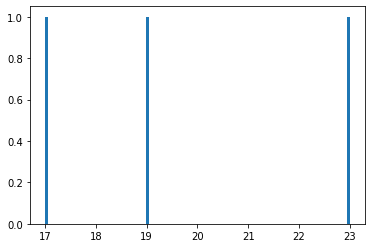

In [25]:
plt.hist(snrs, bins=100)